# Problem Statement



ABC is an online content sharing platform that enables users to create, upload and share the content in the form of videos. It includes videos from different genres like entertainment, education, sports, technology and so on. The maximum duration of video is 10 minutes.

Users can like, comment and share the videos on the platform. 

Based on the user’s interaction with the videos, engagement score is assigned to the video with respect to each user. Engagement score defines how engaging the content of the video is. 

Understanding the engagement score of the video improves the user’s interaction with the platform. It defines the type of content that is appealing to the user and engages the larger audience.



# Objective



The main objective of the problem is to develop the machine learning approach to predict the engagement score of the video on the user level.

In [983]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score,mean_squared_error,make_scorer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
import optuna
from scipy.stats import boxcox

In [946]:
data_train = pd.read_csv('train_0OECtn8.csv')
data_test  = pd.read_csv('test_1zqHu22.csv')

In [947]:
data_train.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views,engagement_score
0,1,19990,37,128,24,Male,Student,180,1000,4.33
1,2,5304,32,132,14,Female,Student,330,714,1.79
2,3,1840,12,24,19,Male,Student,180,138,4.35
3,4,12597,23,112,19,Male,Student,220,613,3.77
4,5,13626,23,112,27,Male,Working Professional,220,613,3.13


In [948]:
data_test.head()

,row_id,user_id,category_id,video_id,age,gender,profession,followers,views
0,89198,7986,12,42,14,Male,Student,180,138
1,89199,11278,34,115,14,Male,Student,230,840
2,89200,17245,8,110,44,Female,Working Professional,280,628
3,89201,9851,16,137,18,Male,Student,270,462
4,89202,16008,34,96,47,Female,Other,230,840


### Check for Null/missing values in dataset

In [949]:
data_train.isnull().sum()

row_id              0
user_id             0
category_id         0
video_id            0
age                 0
gender              0
profession          0
followers           0
views               0
engagement_score    0
dtype: int64

No null values present in the dataset.

In [950]:
categoricalcolumns = list((data_train.select_dtypes(include=np.object).columns))  ## features with categorical data
numericalcolumns   = list((data_train.select_dtypes(include=np.int64).columns))   ## feature with numerical data

print('Numerical features are :',numericalcolumns)
print('Categorical features are:',categoricalcolumns)


Numerical features are : ['row_id', 'user_id', 'category_id', 'video_id', 'age', 'followers', 'views']
Categorical features are: ['gender', 'profession']


In [951]:
# Removing Row_id feature

row_id = data_test.row_id.values

data_train = data_train.drop('row_id',axis=1)
data_test = data_test.drop('row_id',axis=1)

# Exploratory Data Analysis

In [952]:
data_train.describe()

,user_id,category_id,video_id,age,followers,views,engagement_score
count,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000,89197.000000
mean,13881.909806,18.323733,77.715383,24.848616,252.460172,502.980268,3.487797
std,8005.582771,11.675154,48.469656,8.955535,46.094468,268.569482,0.863498
min,1.000000,1.000000,1.000000,10.000000,160.000000,30.000000,0.000000
25%,6945.000000,8.000000,34.000000,18.000000,230.000000,229.000000,2.900000
50%,13892.000000,16.000000,76.000000,23.000000,240.000000,467.000000,3.710000
75%,20819.000000,26.000000,120.000000,32.000000,280.000000,714.000000,4.150000
max,27734.000000,47.000000,175.000000,68.000000,360.000000,1000.000000,5.000000


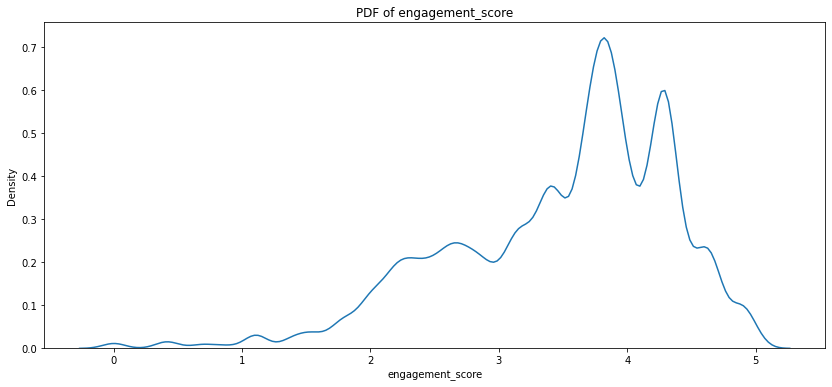

In [953]:
plt.figure(figsize=(14,6))
ax = sns.kdeplot(x='engagement_score',data=data_train)
ax.set_title('PDF of engagement_score')
plt.show()

- Majority of engagement_score falls between 3.5 and 4.5

In [954]:
data_categorical = data_train.select_dtypes(include=object)
print(data_categorical.gender.value_counts())
print('*'*30)
print(data_categorical.profession.value_counts())


Male      52397
Female    36800
Name: gender, dtype: int64
******************************
Student                 44638
Other                   26840
Working Professional    17719
Name: profession, dtype: int64


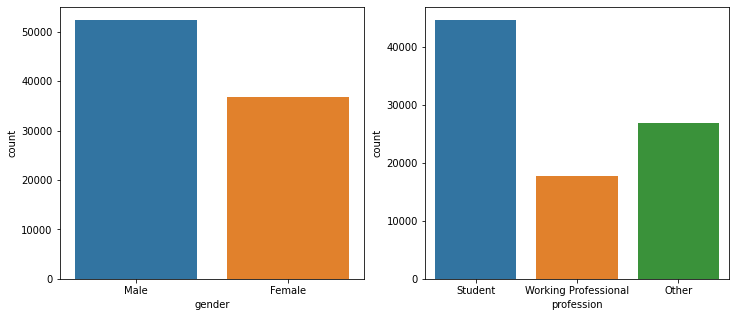

In [955]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.countplot(x='gender',data=data_train,ax=ax[0])
sns.countplot(x='profession',data=data_train,ax=ax[1])
plt.show()

- Males are more than females
- There are more number of students than working professional and others

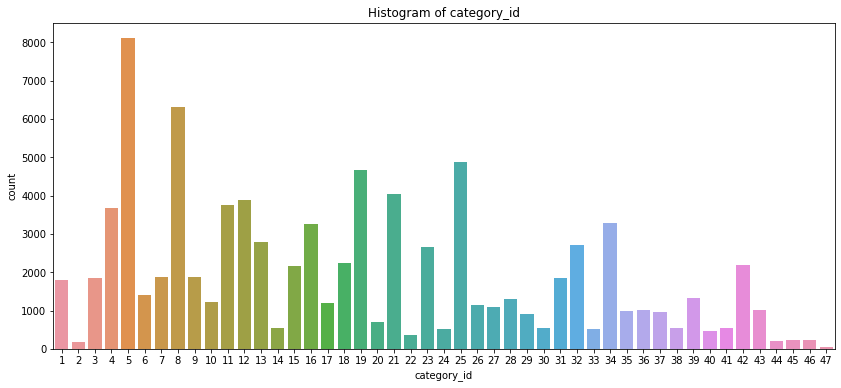

In [956]:
plt.figure(figsize=(14,6))
ax = sns.countplot(x='category_id',data=data_train)
ax.set_title('Histogram of category_id')
plt.show()

Most occured category of video in the dataset is the 5th catgory followed by 8th, 25th and 19th 

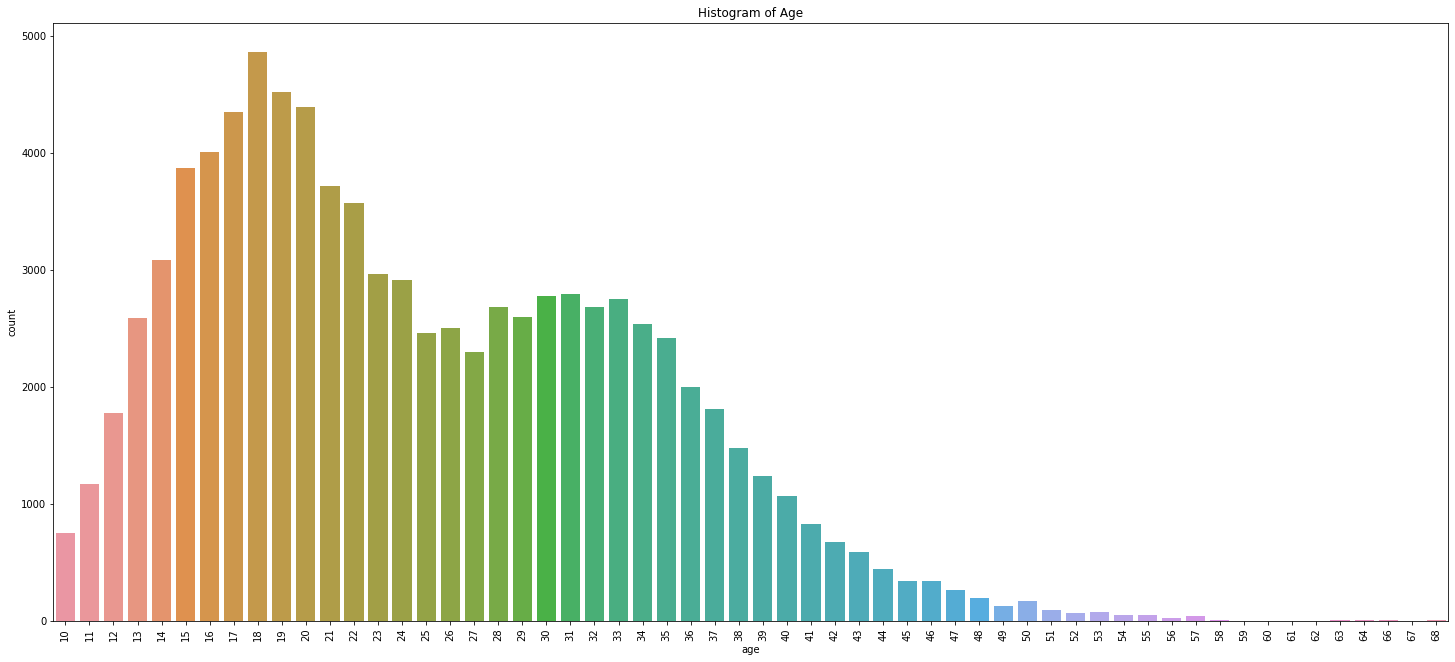

In [11]:
plt.figure(figsize=(25,11))
ax = sns.countplot(x='age',data=data_train)
ax.set_title('Histogram of Age')
plt.xticks(rotation=90)
plt.show()

The dataset contains maximum number of observation from the age group between 16 and 21, with 18 being the most observed age. 

### Bivariate Analysis - Pair plot

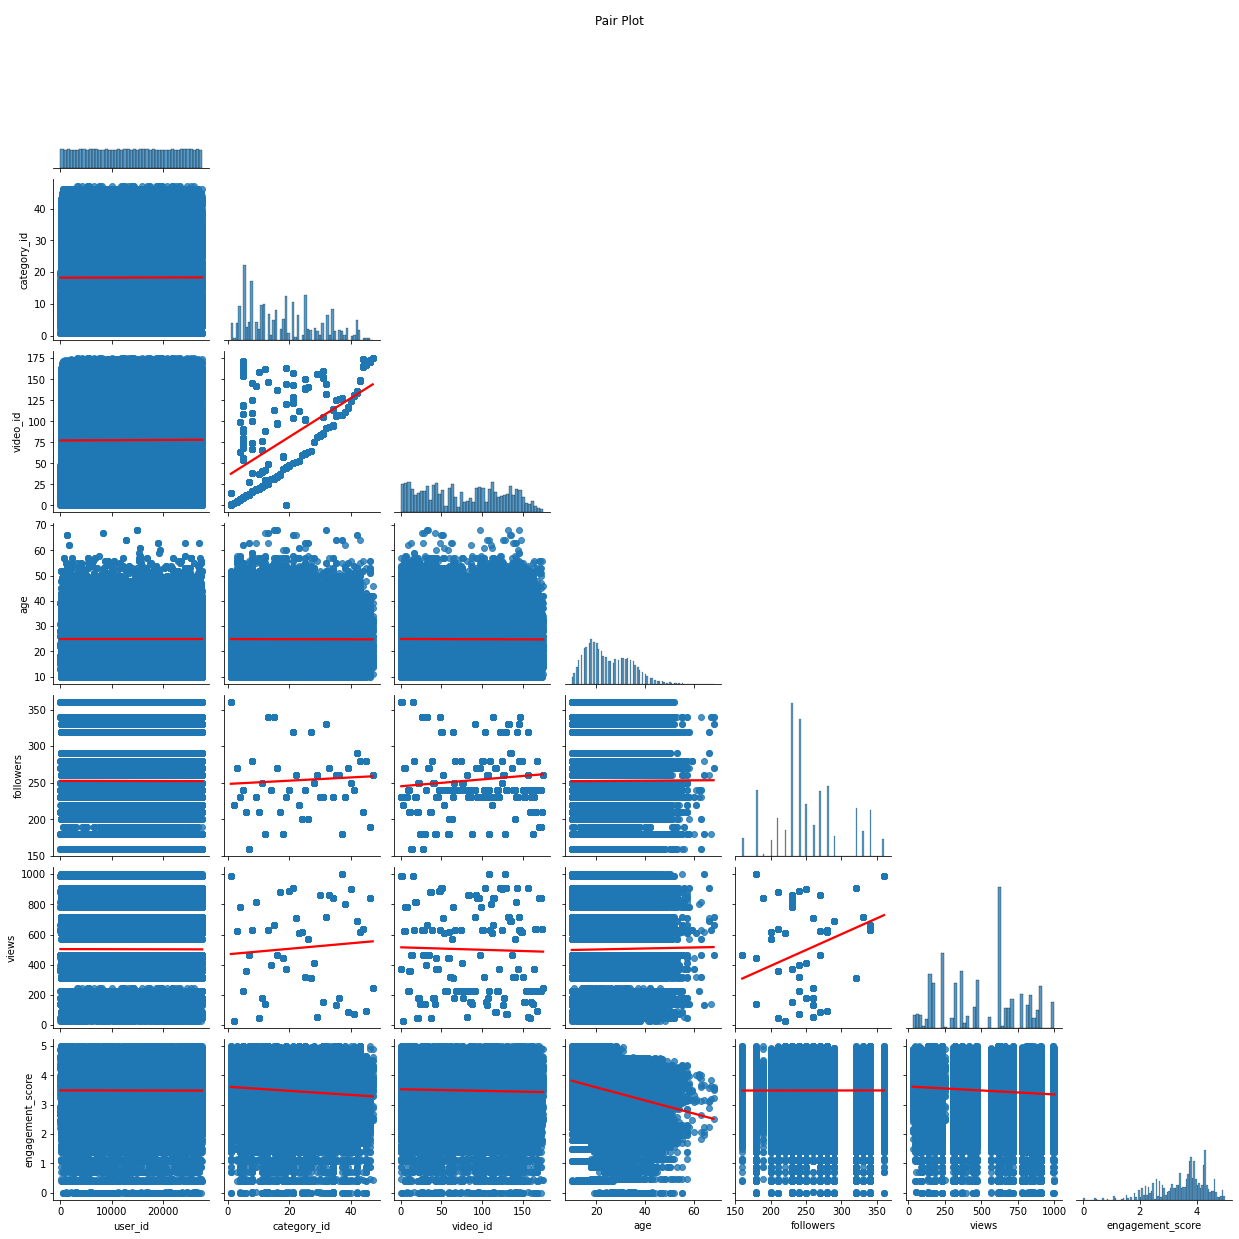

In [14]:
ax = sns.pairplot(data_train,kind='reg',corner=True, plot_kws={'line_kws':{'color':'red'}})
ax.fig.suptitle('Pair Plot',fontsize='large')
plt.show()

- From the pair plot most features are not at all dependent, but however the features showing some dependance with each other are category_id with video_id and video_id with followers.



In [957]:
## splitting dataset to dependent and independent variables 

label_train = data_train.engagement_score.values
data_train  = data_train.drop('engagement_score',axis=1)

### Encoding Categorical Features

- For encoding we will use One hot encoding for 'gender' feature and label encoding for 'profession' feature

In [958]:
data_train[['gender_ohe_1','gender_ohe_2']] = pd.get_dummies(data_train['gender'])
data_test[['gender_ohe_1','gender_ohe_2']] = pd.get_dummies(data_test['gender'])

## removing gender column after one hot encoding
data_train = data_train.drop('gender',axis=1)
data_test = data_test.drop('gender',axis=1)

In [959]:
# Labelencoding for categorical features

le = LabelEncoder()
categorical = data_train.select_dtypes(include='object').columns
for i in categorical:
    data_train[i] = le.fit_transform(data_train[i])
    data_test[i] = le.fit_transform(data_test[i])

In [960]:
data_train.head()

,user_id,category_id,video_id,age,profession,followers,views,gender_ohe_1,gender_ohe_2
0,19990,37,128,24,1,180,1000,0,1
1,5304,32,132,14,1,330,714,1,0
2,1840,12,24,19,1,180,138,0,1
3,12597,23,112,19,1,220,613,0,1
4,13626,23,112,27,2,220,613,0,1


#### Correlation Matrix

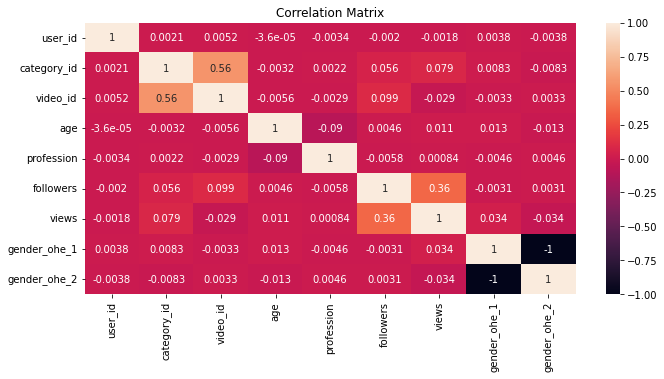

In [961]:
plt.figure(figsize=(11,5))
sns.heatmap(data_train.corr(),annot=True)
plt.title("Correlation Matrix")
plt.show()

- From the correlation matrix, the features 'followers'-'views' and 'category_id'-'video_id' has some correlation with each other, but all of these has very less correlation with the engagement_score.



- Most of the features have very less correlation with the engagement scores. The highest correlation is seen with 'gender' feature which is a correlation of 0.41. This is hpwever not so great gbut however it can be said that the engagement score tends to be higher when the gender is Male.


- Age also has some negative correlation of -0.23 with the engagement score. This could mean if age is less the engagement score tends to be higher.


- As the correlation is not considerable great, information about the important features cannot be infered from the correlation plot


- Before feature engineering we will remove video_id feature as it has some correlation with category_id.

In [978]:
data_train = data_train.drop('video_id',axis=1)
data_test = data_test.drop('videoi_id',axis=1)

# Feature Engineering

- Some transformational features was tried out and tested like log(x) ,exp(x), reciprocal(x). And one feature showing slight improvement in performance was boxcox transform of'views'. 


- One other feature that showed slight improvement was views per followers(views/followers)

In [963]:
vpf_train = (data_train.views / data_train.followers)
vpf_test = (data_test.views / data_test.followers)
data_train['vpf'] = vpf_train
data_test['vpf'] = vpf_test

In [964]:
data_train['boxcox_views'], lamda = boxcox(data_train['views'])
data_test['boxcox_views'], lamda = boxcox(data_test['views'])

In [967]:
data_train.head()

,user_id,category_id,age,profession,followers,views,gender_ohe_1,gender_ohe_2,vpf,boxcox_views
0,19990,37,24,1,180,1000,0,1,5.555556,168.372581
1,5304,32,14,1,330,714,1,0,2.163636,133.172693
2,1840,12,19,1,180,138,0,1,0.766667,41.893979
3,12597,23,19,1,220,613,0,1,2.786364,119.734310
4,13626,23,27,2,220,613,0,1,2.786364,119.734310


#### Autoencoder for feature engineering

In [750]:
# Input information
col_num = data_train.shape[1]
input_dim = Input(shape=(col_num,))

# Encoding information
encoding_dim = 2
encoded = Dense(encoding_dim, activation='relu')(input_dim)
e = BatchNormalization()(encoded)
e = LeakyReLU()(e)

n_bottleneck = 3
bottleneck = Dense(n_bottleneck)(e)

# Decoding information
decoded = Dense(col_num, activation='linear')(bottleneck)
d = BatchNormalization()(decoded)
d = LeakyReLU()(d)
output = Dense(col_num, activation='linear')(d)

# Autoencoder information (encoder + decoder)
autoencoder = Model(inputs=input_dim, outputs=output)

# Train the autoencoder
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.fit(data_train, label_train, epochs=10, batch_size=32, shuffle=True)

# Encoder information for feature extraction
encoder = Model(inputs=input_dim, outputs=bottleneck)
encoded_input = Input(shape=(encoding_dim,))

encoded_output_train = encoder.predict(data_train)
encoded_output_test  = encoder.predict(data_test)

Epoch 1/10
2440/2440 [==============================] - 7s 3ms/step - loss: 12.8847
Epoch 2/10
2440/2440 [==============================] - 6s 3ms/step - loss: 12.7683
Epoch 3/10
2440/2440 [==============================] - 6s 3ms/step - loss: 12.6312
Epoch 4/10
2440/2440 [==============================] - 6s 3ms/step - loss: 12.4831
Epoch 5/10
2440/2440 [==============================] - 6s 3ms/step - loss: 12.3209
Epoch 6/10
2440/2440 [==============================] - 6s 3ms/step - loss: 12.1456
Epoch 7/10
2440/2440 [==============================] - 6s 3ms/step - loss: 11.9556
Epoch 8/10
2440/2440 [==============================] - 6s 3ms/step - loss: 11.7530
Epoch 9/10
2440/2440 [==============================] - 7s 3ms/step - loss: 11.5373
Epoch 10/10
2440/2440 [==============================] - 6s 3ms/step - loss: 11.3145
[[-0.00548545  0.00137256  0.00050612]
 [-0.00548545  0.00137256  0.00050612]
 [-0.00548545  0.00137256  0.00050612]
 [-0.00548545  0.00137256  0.00050612]
 [-

In [754]:
data_test[['ae_1','ae_2','ae_3']] = encoded_output_test
data_train[['ae_1','ae_2','ae_3']] = encoded_output_train

- Adding autoencoded features were tried out, but the performance of the model did not increase, hence not considering for final submission

### Train_test_Split

Dataset is split into  train and test. The splitting is done in such a way to obtain the number of test observatins almost same as the provided Test set

In [968]:
X_train,X_test, Y_train, Y_test = train_test_split(data_train, label_train,stratify=label_train,
                                                random_state=10, test_size=0.1247)

X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((78074, 10), (11123, 10), (78074,), (11123,))

# Machine Learning Models

In [969]:
## standardizing data for neural network model

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_train_std = pd.DataFrame(X_train_std,columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std,columns=X_test.columns)


#### GradientBoost Regressor

In [224]:
clf = GradientBoostingRegressor(n_estimators=1000,max_depth=10,criterion='mse')
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)

In [225]:
r2_score(Y_test,y_pred)

0.43032897683921534

#### XGBRegressor

In [16]:
## making a scoring function

def R2(y_true,y_pred):    
    r2 = r2_score(y_true, y_pred)
    return r2
def r2_scorer():
    return make_scorer(R2, greater_is_better=True) 

In [526]:

model = XGBRegressor()
paramgrid = {
 'n_estimators':[1000,200,3000],
 'gamma': np.uniform ('gamma', 1,9),
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'learning_rate':[0.05,0.1,0.15,1]   
}
grid = GridSearchCV(estimator=model, param_grid=paramgrid, scoring=r2_scorer(),n_jobs=-1,cv=3)
grid.fit(data_train_std,label_train)
grid.best_params_

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [975]:
clf = XGBRegressor(n_estimators=2160,max_depth=7,min_child_weight=1,subsample=1,colsample_bytree=1,
                   learning_rate=0.18)
clf.fit(X_train,Y_train)

y_pred = clf.predict(X_test)
y_pred

array([4.1024537, 3.7903972, 2.4431634, ..., 3.068611 , 3.7427516,
       2.85174  ], dtype=float32)

In [974]:
r2_score(Y_test,y_pred)

0.4747392476411997

#### XGBRegressor hyperparamter tuning with optuna

In [127]:
def objective(trial,data=data_train,target=label_train):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.1247,random_state=42) 
    param = {
        
        'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.6,0.8, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.018, 0.18]),
        'n_estimators': 2000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    model = XGBRegressor(**param)      
    model.fit(train_x,train_y)    
    preds = model.predict(test_x)    
    r2 = r2_score(test_y, preds)
    
    return r2

In [128]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-02-13 09:51:21,047] A new study created in memory with name: no-name-1da06678-aace-4aae-9f48-260b64da5781
[I 2022-02-13 09:51:36,250] Trial 0 finished with value: 0.36681498820474157 and parameters: {'lambda': 6.719851745091477, 'alpha': 0.0018382401484771304, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.18, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 28}. Best is trial 0 with value: 0.36681498820474157.
[I 2022-02-13 09:52:21,236] Trial 1 finished with value: 0.3784747207625264 and parameters: {'lambda': 1.4459952306459136, 'alpha': 0.016958455882349205, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 38}. Best is trial 1 with value: 0.3784747207625264.
[I 2022-02-13 09:52:36,130] Trial 2 finished with value: 0.36729550488733975 and parameters: {'lambda': 0.0038531097888218975, 'alpha': 0.007547452487319791, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.18, 

[I 2022-02-13 10:05:59,266] Trial 24 finished with value: 0.3821337745301865 and parameters: {'lambda': 0.0010219843935291237, 'alpha': 0.7465164436435526, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 50}. Best is trial 21 with value: 0.3937101009621501.
[I 2022-02-13 10:06:58,468] Trial 25 finished with value: 0.3947705716841249 and parameters: {'lambda': 0.0037353962914378302, 'alpha': 0.16431103416045803, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 2}. Best is trial 25 with value: 0.3947705716841249.
[I 2022-02-13 10:07:29,823] Trial 26 finished with value: 0.3814612135050881 and parameters: {'lambda': 0.0052127299818409455, 'alpha': 0.17762188267775134, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 64}. Best is trial 25 with value: 0.394770571684

[I 2022-02-13 10:24:01,803] Trial 48 finished with value: 0.3755574795850396 and parameters: {'lambda': 0.03442386110267787, 'alpha': 1.3363168089114326, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 170}. Best is trial 45 with value: 0.40690806908813737.
[I 2022-02-13 10:24:40,748] Trial 49 finished with value: 0.34456859745438606 and parameters: {'lambda': 1.924072606326609, 'alpha': 3.1259352543358734, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.18, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 193}. Best is trial 45 with value: 0.40690806908813737.


Number of finished trials: 50
Best trial: {'lambda': 0.0030497060993055158, 'alpha': 0.6467201637794217, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 1}


#### LightGBM Regressor

In [849]:
clf = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=10000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

clf.fit(X_train,Y_train)

y_pred = clf.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [850]:
r2_score(Y_test,y_pred)

0.3510941911774087

#### Neural Network

In [726]:
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential, Input
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Model
from keras import backend as K

In [857]:

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='he_normal',input_dim = X_train_std.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(512, kernel_initializer='he_normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='he_normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='he_normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='he_normal',activation='linear'))

# Compile the network :

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

NN_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mean_squared_error', metrics=[coeff_determination])

NN_model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 128)               1280      
_________________________________________________________________
dense_84 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_85 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_86 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 129       
Total params: 231,681
Trainable params: 231,681
Non-trainable params: 0
_________________________________________________________________


In [860]:
NN_model.fit(X_train_std, Y_train, epochs=10, batch_size=32)
y_pred = NN_model.predict(X_test_std)

r2_score(Y_test,y_pred)

Epoch 1/10
2440/2440 [==============================] - 5s 2ms/step - loss: 0.4932 - coeff_determination: 0.3049
Epoch 2/10
2440/2440 [==============================] - 5s 2ms/step - loss: 0.4918 - coeff_determination: 0.3071
Epoch 3/10
2440/2440 [==============================] - 5s 2ms/step - loss: 0.4908 - coeff_determination: 0.3074
Epoch 4/10
2440/2440 [==============================] - 5s 2ms/step - loss: 0.4915 - coeff_determination: 0.3057
Epoch 5/10
2440/2440 [==============================] - 5s 2ms/step - loss: 0.4907 - coeff_determination: 0.3068
Epoch 6/10
2440/2440 [==============================] - 5s 2ms/step - loss: 0.4900 - coeff_determination: 0.3103
Epoch 7/10
2440/2440 [==============================] - 5s 2ms/step - loss: 0.4889 - coeff_determination: 0.3100
Epoch 8/10
2440/2440 [==============================] - 5s 2ms/step - loss: 0.4889 - coeff_determination: 0.3113
Epoch 9/10
2440/2440 [==============================] - 5s 2ms/step - loss: 0.4872 - coeff_deter

0.33575814067397425

#### Random Forest Regressor

In [555]:
## para,eter tuning using gridsearchCV

model = RandomForestRegressor()
param = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 300, 500]
}
grid = GridSearchCV(estimator=model, param_grid=param, scoring=r2_scorer(),n_jobs=-1,cv=3)
grid.fit(data_train,label_train)
grid.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 500}

In [254]:
clf = RandomForestRegressor(n_estimators=500,min_samples_leaf=5,max_features=3,min_samples_split=12,bootstrap=True)
clf.fit(X_train,Y_train)

y_pred = clf.predict(X_test)

In [255]:
r2_score(Y_test,y_pred)

0.36315233106833356

#### Stacking Regressor

In [274]:
basemodels= []

    # define the base models
basemodels.append(('RF', RandomForestRegressor(n_estimators=500,min_samples_leaf=5,max_features=3,
                                                min_samples_split=12,bootstrap=True)))
basemodels.append(('XGB',XGBRegressor(n_estimators=2000,max_depth=7,min_child_weight=1,subsample=1,
                                          colsample_bytree=1,learning_rate=0.18) ))
basemodels.append(('GBR',GradientBoostingRegressor(n_estimators=1000,max_depth=10,criterion='mse') ))
    
    # define meta learner model
metamodel = LinearRegression()
    # define the stacking ensemble
model = StackingRegressor(estimators=basemodels, final_estimator=metamodel , cv=5)

model.fit(data_train,label_train)


StackingRegressor(cv=5,
                  estimators=[('RF',
                               RandomForestRegressor(max_features=3,
                                                     min_samples_leaf=5,
                                                     min_samples_split=12,
                                                     n_estimators=500)),
                              ('XGB',
                               XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.18,
                                            max_de...
                                            min_chil

In [267]:
y_pred = model.predict(data_test)
r2_score(Y_test,y_pred)

# Observations

- Several models were tried out like Linear regression,KNN Regressor, Random Forest regressor, Gradient boost regressor, XGBoost regressor, LighGBM regressor and a Neural Network Model.


- Finally a staking Regressor that used some of the other top performing models aas base models, was also tried out.


- Out of all the models, it was found that the XGBoost Regressor obtained the best R2 score on validation data and hence it will be used for making the final prediction on the entire data provided. (data_train)



In [980]:
clf = XGBRegressor(n_estimators=2160,max_depth=7,min_child_weight=1,subsample=1,colsample_bytree=1,
                   learning_rate=0.18)
clf.fit(data_train,label_train)

y_pred = clf.predict(data_test)
y_pred

array([4.082949 , 3.9255993, 2.3630624, ..., 3.0272083, 3.6878057,
       2.8658707], dtype=float32)

#### Create submission file

In [981]:
data_final = {'row_id':row_id,'engagement_score':y_pred}

final_submission = pd.DataFrame(data_final)
final_submission.to_csv('final_submission_xgbregressor_10.csv',index=False)

In [982]:
final_submission

,row_id,engagement_score
0,89198,4.082949
1,89199,3.925599
2,89200,2.363062
3,89201,3.023596
4,89202,1.968168
...,...,...
11116,100314,3.813411
11117,100315,3.409731
11118,100316,3.027208
11119,100317,3.687806
